In [1]:
import numpy as np
import modcma.c_maes as modcma
import ioh
import pandas as pd 
import matplotlib.pyplot as plt

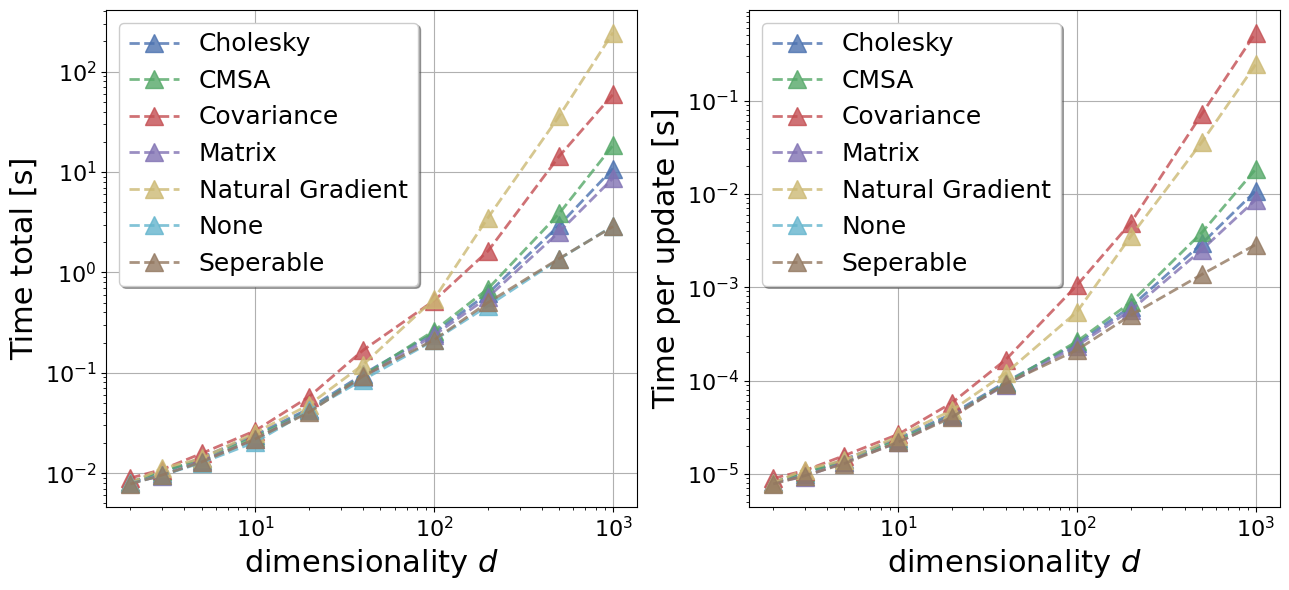

In [161]:
stats = pd.read_csv("time_stats.csv")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

n = np.arange(2, 1000)
c = 0.01

colors = [
    "#4C72B0",  # blue
    "#55A868",  # green
    "#C44E52",  # red
    "#8172B3",  # purple
    "#CCB974",  # yellow-brown
    "#64B5CD",  # cyan
    "#937860",  # brown-gray
]

for (method, group), color in zip(stats.groupby("method", sort=True), colors):
    label = method.title().replace("_", " ") if method != "CMSA" else method
    time_gb = group.groupby("dim")['time']

    plot_dat = pd.merge(
        time_gb.median().rename("mean"), 
        time_gb.std().rename("std"),
        on="dim"
    ).merge(group.groupby("dim")['n_updates'].mean().rename("n_updates"), on="dim")

    ax1.plot(
        plot_dat.index, plot_dat['mean'], 
        label=label, 
        marker="^",
        markersize=13,
        linestyle='dashed',
        alpha=.8,
        linewidth=2,
        color=color
    )

    ax2.plot(
        plot_dat.index, plot_dat['mean'] / plot_dat['n_updates'], 
        label=label, 
        marker="^",
        markersize=13,
        linestyle='dashed',
        alpha=.8,
        linewidth=2,
        color=color
    )

for ax in ax1, ax2:
    ax.grid(which="major")
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=18, ncol=1, fancybox=True, shadow=True) 
    ax.set_xlabel(r"dimensionality $d$", fontsize=22)

ax1.set_ylabel("Time total [s]", fontsize=22)
ax2.set_ylabel("Time per update [s]", fontsize=22)
plt.tight_layout()
plt.savefig("time_matrix_adaptation.png", dpi=500)

In [59]:
group.groupby("dim")['n_updates'].mean()

dim
2       1000.0
3       1000.0
5       1000.0
10      1000.0
20      1000.0
40      1000.0
100     1000.0
200     1000.0
500     1000.0
1000    1000.0
Name: n_updates, dtype: float64